# Multi-period OPF example

In [1]:
import os
from pyomo.environ import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from nygrid.run_nygrid import NYGrid


In [2]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

grid_data_dir = os.path.join(data_dir, 'grid')
if not os.path.exists(grid_data_dir):
    raise FileNotFoundError('Grid data directory not found.')

print('Grid data directory: {}'.format(grid_data_dir))

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))

Grid data directory: /home/by276/models/NYgrid-python/data/grid
Figure directory: /home/by276/models/NYgrid-python/figures
Results directory: /home/by276/models/NYgrid-python/results


## Read grid data

In [3]:
start_date = datetime(2018, 1, 5, 0, 0, 0)
end_date = datetime(2018, 1, 16, 0, 0, 0)
timestamp_list = pd.date_range(start_date, end_date, freq='1D')

# Read load profile
load_profile = pd.read_csv(os.path.join(grid_data_dir, f'load_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
load_profile.index.freq = 'H'


# Read generation profile
gen_profile = pd.read_csv(os.path.join(grid_data_dir, f'gen_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
gen_profile.index.freq = 'H'

# Read generator capacity limit profile
genmax_profile = pd.read_csv(os.path.join(grid_data_dir, f'genmax_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
genmax_profile.index.freq = 'H'

genmin_profile = pd.read_csv(os.path.join(grid_data_dir, f'genmin_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
genmin_profile.index.freq = 'H'

# Read generator ramp rate profile
genramp30_profile = pd.read_csv(os.path.join(grid_data_dir, f'genramp30_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
genramp30_profile.index.freq = 'H'

# Read generator cost profile (linear)
gencost0_profile = pd.read_csv(os.path.join(grid_data_dir, f'gencost0_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
gencost0_profile.index.freq = 'H'

gencost1_profile = pd.read_csv(os.path.join(grid_data_dir, f'gencost1_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
gencost1_profile.index.freq = 'H'


## Multi-period OPF

### Without initial conditions

In [4]:
# Only run for one day
d = 0
start_datetime = timestamp_list[d]
end_datetime = timestamp_list[d+1]
print(f'Start time: {start_datetime}')
print(f'End time: {end_datetime}')

Start time: 2018-01-05 00:00:00
End time: 2018-01-06 00:00:00


In [5]:
# Read MATPOWER case file
ppc_filename = os.path.join(data_dir, 'ny_grid.mat')

nygrid_sim = NYGrid(ppc_filename, 
                    start_datetime=start_datetime.strftime('%Y-%m-%d'), 
                    end_datetime=end_datetime.strftime('%Y-%m-%d'), 
                    verbose=True)

# Read grid data
nygrid_sim.get_load_data(load_profile)
nygrid_sim.get_gen_data(gen_profile)
nygrid_sim.get_genmax_data(genmax_profile)
nygrid_sim.get_genmin_data(genmin_profile)
nygrid_sim.get_genramp_data(genramp30_profile)
nygrid_sim.get_gencost_data(gencost0_profile, gencost1_profile)

# Process ppc
nygrid_sim.process_ppc()

# Set generator initial condition
nygrid_sim.get_gen_init_data(gen_init=None)

# Check input
nygrid_sim.check_input_dim()

Initializing NYGrid run...
NYGrid run starting on: 2018-01-05 00:00:00
NYGrid run ending on: 2018-01-06 00:00:00
NYGrid run duration: 1 day, 0:00:00


In [6]:
nygrid_sim.gen_init

In [7]:
# Initialize single period OPF
model_multi_opf_0 = nygrid_sim.create_multi_opf()
nygrid_sim.show_model_dim(model_multi_opf_0)

[    0.00] Starting timer ...
[+   1.15] Created constraints for time step 0 ...
[+   1.08] Created constraints for time step 1 ...
[+   1.10] Created constraints for time step 2 ...
[+   1.09] Created constraints for time step 3 ...
[+   1.08] Created constraints for time step 4 ...
[+   1.08] Created constraints for time step 5 ...
[+   1.08] Created constraints for time step 6 ...
[+   1.08] Created constraints for time step 7 ...
[+   1.08] Created constraints for time step 8 ...
[+   1.08] Created constraints for time step 9 ...
[+   1.13] Created constraints for time step 10 ...
[+   1.08] Created constraints for time step 11 ...
[+   1.08] Created constraints for time step 12 ...
[+   1.08] Created constraints for time step 13 ...
[+   1.08] Created constraints for time step 14 ...
[+   1.08] Created constraints for time step 15 ...
[+   1.08] Created constraints for time step 16 ...
[+   1.09] Created constraints for time step 17 ...
[+   1.10] Created constraints for time step

In [8]:
solver = SolverFactory('glpk')

results_multi_opf = solver.solve(model_multi_opf_0, tee=True)

if nygrid_sim.check_status(results_multi_opf):
     print('%.2f' % model_multi_opf_0.obj())

# Get results
results_0 = nygrid_sim.get_results_multi_opf(model_multi_opf_0)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmp0jjt3i2q.glpk.raw --wglp /tmp/tmp9s65evnr.glpk.glp --cpxlp
 /tmp/tmpensnjpo0.pyomo.lp
Reading problem data from '/tmp/tmpensnjpo0.pyomo.lp'...
36468 rows, 10751 columns, 67035 non-zeros
193973 lines were read
Writing problem data to '/tmp/tmp9s65evnr.glpk.glp'...
165801 lines were written
GLPK Simplex Optimizer 5.0
36468 rows, 10751 columns, 67035 non-zeros
Preprocessing...
6331 rows, 8425 columns, 23237 non-zeros
Scaling...
 A: min|aij| =  1.061e-01  max|aij| =  5.058e+02  ratio =  4.766e+03
GM: min|aij| =  4.212e-02  max|aij| =  2.374e+01  ratio =  5.636e+02
EQ: min|aij| =  1.774e-03  max|aij| =  1.000e+00  ratio =  5.636e+02
Constructing initial basis...
Size of triangular part is 6281
      0: obj =   2.650722785e+08 inf =   2.842e+03 (1169)
   6651: obj =   2.559431387e+08 inf =   1.088e-14 (0) 38
* 11876: obj =   2.064072176e+08 inf =   0.000e+00 (0) 25
OPTIMAL LP SOLUTION FOUND
Time used:

### With initial conditions

In [9]:
# Only run for one day
d = 1
start_datetime = timestamp_list[d]
end_datetime = timestamp_list[d+1]
print(f'Start time: {start_datetime}')
print(f'End time: {end_datetime}')

Start time: 2018-01-06 00:00:00
End time: 2018-01-07 00:00:00


In [10]:
# Read MATPOWER case file
ppc_filename = os.path.join(data_dir, 'ny_grid.mat')

nygrid_sim = NYGrid(ppc_filename, 
                    start_datetime=start_datetime.strftime('%Y-%m-%d'), 
                    end_datetime=end_datetime.strftime('%Y-%m-%d'), 
                    verbose=True)

# Read grid data
nygrid_sim.get_load_data(load_profile)
nygrid_sim.get_gen_data(gen_profile)
nygrid_sim.get_genmax_data(genmax_profile)
nygrid_sim.get_genmin_data(genmin_profile)
nygrid_sim.get_genramp_data(genramp30_profile)
nygrid_sim.get_gencost_data(gencost0_profile, gencost1_profile)

# Process ppc
nygrid_sim.process_ppc()

# Set generator initial condition
last_gen = nygrid_sim.get_last_gen(model_multi_opf_0)
nygrid_sim.get_gen_init_data(gen_init=last_gen)

# Check input
nygrid_sim.check_input_dim()

Initializing NYGrid run...
NYGrid run starting on: 2018-01-06 00:00:00
NYGrid run ending on: 2018-01-07 00:00:00
NYGrid run duration: 1 day, 0:00:00


In [11]:
# Initialize single period OPF
model_multi_opf_1 = nygrid_sim.create_multi_opf()
nygrid_sim.show_model_dim(model_multi_opf_1)

[    0.00] Starting timer ...
[+   1.13] Created constraints for time step 0 ...
[+   1.13] Created constraints for time step 1 ...
[+   1.10] Created constraints for time step 2 ...
[+   1.09] Created constraints for time step 3 ...
[+   1.18] Created constraints for time step 4 ...
[+   1.09] Created constraints for time step 5 ...
[+   1.09] Created constraints for time step 6 ...
[+   1.10] Created constraints for time step 7 ...
[+   1.12] Created constraints for time step 8 ...
[+   1.09] Created constraints for time step 9 ...
[+   1.09] Created constraints for time step 10 ...
[+   1.09] Created constraints for time step 11 ...
[+   1.12] Created constraints for time step 12 ...
[+   1.09] Created constraints for time step 13 ...
[+   1.09] Created constraints for time step 14 ...
[+   1.10] Created constraints for time step 15 ...
[+   1.11] Created constraints for time step 16 ...
[+   1.10] Created constraints for time step 17 ...
[+   1.09] Created constraints for time step

In [12]:
solver = SolverFactory('glpk')

results_multi_opf = solver.solve(model_multi_opf_1, tee=True)

if nygrid_sim.check_status(results_multi_opf):
     print('%.2f' % model_multi_opf_1.obj())

# Get results
results_1 = nygrid_sim.get_results_multi_opf(model_multi_opf_1)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmpbr_zhgpg.glpk.raw --wglp /tmp/tmpeaxkqkj2.glpk.glp --cpxlp
 /tmp/tmpjcmt4c_n.pyomo.lp
Reading problem data from '/tmp/tmpjcmt4c_n.pyomo.lp'...
37026 rows, 10751 columns, 67593 non-zeros
196205 lines were read
Writing problem data to '/tmp/tmpeaxkqkj2.glpk.glp'...
167475 lines were written
GLPK Simplex Optimizer 5.0
37026 rows, 10751 columns, 67593 non-zeros
Preprocessing...
6250 rows, 8400 columns, 23050 non-zeros
Scaling...
 A: min|aij| =  1.061e-01  max|aij| =  5.058e+02  ratio =  4.766e+03
GM: min|aij| =  4.212e-02  max|aij| =  2.374e+01  ratio =  5.636e+02
EQ: min|aij| =  1.774e-03  max|aij| =  1.000e+00  ratio =  5.636e+02
Constructing initial basis...
Size of triangular part is 6200
      0: obj =   2.923372299e+08 inf =   2.827e+03 (1163)
   6716: obj =   2.743713713e+08 inf =   2.798e-14 (0) 36
* 11458: obj =   2.292844110e+08 inf =   6.661e-16 (0) 23
OPTIMAL LP SOLUTION FOUND
Time used:

## Process the results

In [13]:
# Read thermal generator info table
filename = os.path.join(data_dir, 'genInfo.csv')
gen_info = pd.read_csv(filename)
num_thermal = gen_info.shape[0]
gen_rename = {gen_info.index[i]: gen_info.NYISOName[i] for i in range(num_thermal)}
gen_info

,NYISOName,PTID,Zone,UnitType,FuelType,Latitude,Longitude,maxPower,minPower,maxRampAgc,maxRamp10,maxRamp30,maxRamp60,HeatRateLM_R2,HeatRateQM_R2,BusName,NCOST,cost_1,cost_0
0,Allegany,23514,B,Combined Cycle,Natural Gas,42.508300,-78.066100,66.0,11.0,0.733333,7.333333,22.00,44.0,0.862443,0.891407,62,1,22.682017,-40.234372
1,Arthur Kill ST 2,23512,J,Steam Turbine,Natural Gas,40.591500,-74.202700,349.0,96.0,2.850000,28.500000,85.50,171.0,0.995837,0.995860,82,1,25.306225,736.980064
2,Arthur Kill ST 3,23513,J,Steam Turbine,Natural Gas,40.591500,-74.202700,539.0,1.0,3.108333,31.083333,93.25,186.5,0.986235,0.991460,82,1,25.957282,993.894899
3,Astoria 2,24149,J,Steam Turbine,Natural Gas,40.786900,-73.912200,153.0,1.0,0.808333,8.083333,24.25,48.5,0.987563,0.988910,82,1,31.302863,430.832898
4,Astoria 3,23516,J,Steam Turbine,Fuel Oil 2,40.786900,-73.912200,756.0,40.0,6.033333,60.333333,181.00,362.0,0.996075,0.996269,82,1,66.084194,3680.943877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Shoreham 1,23715,K,Combustion Turbine,Fuel Oil 2,40.957200,-72.866400,52.9,0.0,0.881667,8.816667,26.45,52.9,0.000000,0.000000,80,1,195.331050,0.000000
223,Shoreham 2,23716,K,Jet Engine,Fuel Oil 2,40.957200,-72.866400,18.6,0.0,0.310000,3.100000,9.30,18.6,0.000000,0.000000,80,1,195.331050,0.000000
224,South Cairo,23612,G,Combustion Turbine,Kerosene,42.291275,-73.986452,21.6,0.0,0.360000,3.600000,10.80,21.6,0.000000,0.000000,39,1,195.331050,0.000000
225,Southold 1,23719,K,Combustion Turbine,Fuel Oil 2,41.105900,-72.376100,14.0,0.0,0.233333,2.333333,7.00,14.0,0.000000,0.000000,80,1,195.331050,0.000000


In [14]:
# Format results
results_pg_0 = results_0['PG']
thermal_pg_0 = results_pg_0.iloc[:, :num_thermal]
thermal_pg_0 = thermal_pg_0.rename(columns=gen_rename)
print(thermal_pg_0.head())

results_pg_1 = results_1['PG']
thermal_pg_1 = results_pg_1.iloc[:, :num_thermal]
thermal_pg_1 = thermal_pg_1.rename(columns=gen_rename)
print(thermal_pg_1.head())

                     Allegany  Arthur Kill ST 2  Arthur Kill ST 3  Astoria 2  \
2018-01-05 00:00:00       0.0               0.0               0.0       11.0   
2018-01-05 01:00:00       0.0               0.0               0.0       11.0   
2018-01-05 02:00:00       0.0               0.0               0.0       11.0   
2018-01-05 03:00:00       0.0               0.0               0.0       11.0   
2018-01-05 04:00:00       0.0               0.0               0.0       11.0   

                        Astoria 3  Astoria 5  Astoria CC 1  Astoria CC 2  \
2018-01-05 00:00:00 -1.136868e-11       11.1           0.0         349.0   
2018-01-05 01:00:00  7.815970e-12       11.1           0.0         349.0   
2018-01-05 02:00:00  0.000000e+00       11.1           0.0         349.0   
2018-01-05 03:00:00 -8.526513e-12       11.1           0.0         349.0   
2018-01-05 04:00:00  6.401990e-10       11.1           0.0         349.0   

                     Astoria East Energy - CC1  Astoria East E

In [18]:
def plot_gen(ax, thermal_pg, ii, title=None):

    ax.plot(thermal_pg.index, thermal_pg.iloc[:, ii], marker='*', label='OPF')
    ax.plot(thermal_pg.index, nygrid_sim.gen_profile[:, ii], marker='o', label='historical')
    ax.plot(thermal_pg.index, nygrid_sim.genmax_profile[:, ii], marker='o', label='max')
    ax.plot(thermal_pg.index, nygrid_sim.genmin_profile[:, ii], marker='o', label='min')
    ax.legend()
    ax.set_title(title)

    return ax

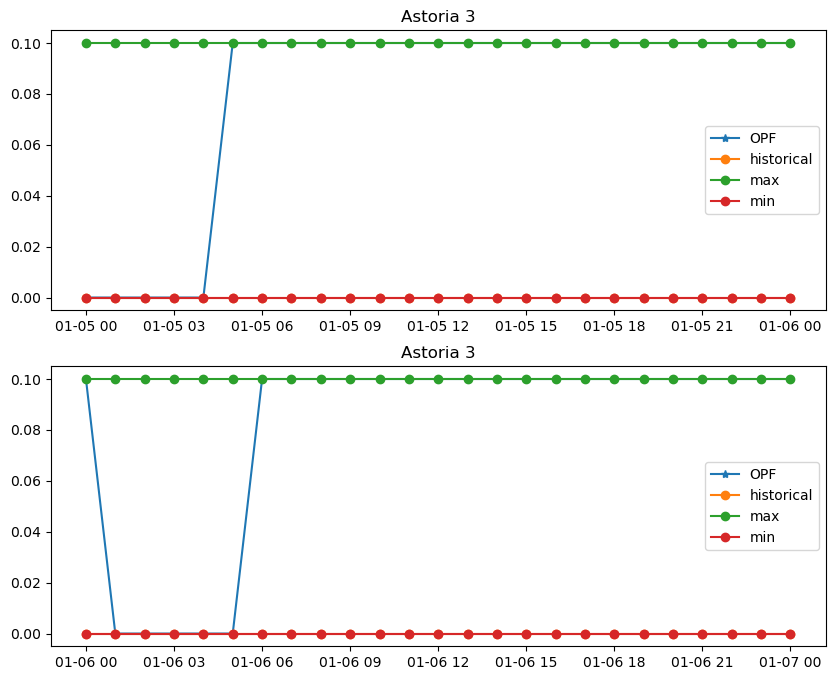

In [26]:
ii = 4
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1 = plot_gen(ax=ax1, thermal_pg=thermal_pg_0, ii=ii, title=gen_info.NYISOName[ii])
ax2 = plot_gen(ax=ax2, thermal_pg=thermal_pg_1, ii=ii, title=gen_info.NYISOName[ii])